In [13]:
'''
多被试的情况下该怎么做呢？
psds

snrs

power

itc

这几个变量都是可以叠加的吧，如果是做被试间，那么所有的数据都应该某人被试内平均过了，不应该有channel信息。

每个被试的这四个值分别存入不同的list当中，再来做统计 和 平均。
'''


'\n多被试的情况下该怎么做呢？\npsds\n\nsnrs\n\npower\n\nitc\n\n这几个变量都是可以叠加的吧，如果是做被试间，那么所有的数据都应该某人被试内平均过了，不应该有channel信息。\n\n每个被试的这四个值分别存入不同的list当中，再来做统计 和 平均。\n'

In [1]:
import  mne
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np

In [2]:
data_path = 'E:\实验\阅读困难\数据处理\pre1nanshi\data\\6epoch_equalization_oddball\\'
#被试2的数据不完整
sub_ids = [
            'pre1001','pre1003','pre1004','pre1005','pre1006'
          ]
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise


In [3]:
list_psds_odd_std = list()

list_snrs_odd_std_mean = list()

list_power_odd_std = list()

list_itc_odd_std = list()


for sub_id in sub_ids:

    epochs_std_BA = mne.read_epochs(data_path+sub_id+'_std_t1ji-epo.fif')
    epochs_std_TA = mne.read_epochs(data_path+sub_id+'_std_t4ji-epo.fif')

    #写错了，名字暂时不变。epochs_std_fuyin
    epochs_std_BA = mne.concatenate_epochs([epochs_std_BA,epochs_std_TA])

    epochs_odd_TA = mne.read_epochs(data_path+sub_id+'_odd_t1ji-epo.fif')
    epochs_odd_BA = mne.read_epochs(data_path+sub_id+'_odd_t4ji-epo.fif')

    epochs_odd_TA = mne.concatenate_epochs([epochs_odd_BA,epochs_odd_TA])

    tmin = 0.
    tmax = 0.8
    fmin = 1.
    fmax = 40.
    sfreq = epochs_std_BA.info['sfreq']

    psds, freqs = mne.time_frequency.psd_welch(
        epochs_std_BA,
        n_fft=int(sfreq * (tmax - tmin)),
        #被试间分析，被试内trial需要先平均了。
        average='mean',
        n_overlap=0, n_per_seg=None,
        tmin=tmin, tmax=tmax,
        fmin=fmin, fmax=fmax,
        window='boxcar',
        verbose=False)
    psds_odd,freqs = mne.time_frequency.psd_welch(
        epochs_odd_TA,
        n_fft=int(sfreq * (tmax - tmin)),
        average='mean',
        n_overlap=0, n_per_seg=None,
        tmin=tmin, tmax=tmax,
        fmin=fmin, fmax=fmax,
        window='boxcar',
        verbose=False)
    # psds是平均过的，这里应该也是
    freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

    snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                        noise_skip_neighbor_freqs=0)
    snrs_odd = snr_spectrum(psds_odd, noise_n_neighbor_freqs=3,
                        noise_skip_neighbor_freqs=0)
    snr_mean = snrs_odd.mean(axis=(0, 1))[freq_range] - snrs.mean(axis=(0, 1))[freq_range]
    snr_std = snrs_odd.std(axis=(0, 1))[freq_range] - snrs.std(axis=(0, 1))[freq_range]
    list_snrs_odd_std_mean.append(snr_mean)

    # 你想让他们进行相减 但是这里的power已经被平均过了
    # 如果是每个被试的epochs单独拿出来算power，然后呢？
    # 还是平均power的好，不然就是以试次为单位了，所以才会没有ITC。
    # 应该是先计算出两个条件的平均power，然后再来相减。最后才是组间统计。
    freqs = np.logspace(*np.log10([1, 50]), num=8)
    freqs = np.linspace(1,40)
    n_cycles = freqs / 2.
    power,itc = tfr_morlet(epochs_std_BA, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1, average=True)
    power_odd, itc_odd = tfr_morlet(epochs_odd_TA, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1, average=True)
    nd_power = power.data
    nd_power_odd = power_odd.data
# 直接相减有问题的。
# 如果不相减，那就是做统计T了，感觉应该也行。
    nd_power_m = nd_power_odd - nd_power
    list_power_odd_std.append(nd_power_m)


    nd_itc = itc.data
    nd_itc_odd = itc_odd.data

# 直接相减有问题的。 m代表 minus
    nd_itc_m = nd_itc_odd - nd_itc
    list_itc_odd_std.append(nd_itc_m)

Reading E:\实验\阅读困难\数据处理\pre1nanshi\data\6epoch_equalization_oddball\pre1001_std_t1ji-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre1nanshi\data\6epoch_equalization_oddball\pre1001_std_t4ji-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
115 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Reading E:\实验\阅读困难\数据处理\pre1nanshi\data\6epoch_equalization_oddball\pre1001_odd_t1ji-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrice

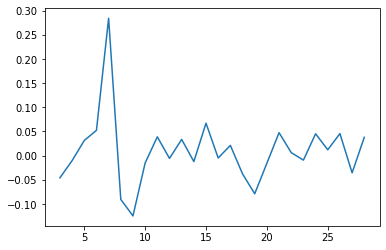

In [4]:
'''
进行组平均
'''
import statistics
snr_mean_group = sum(list_snrs_odd_std_mean)/len(list_snrs_odd_std_mean)
plt.plot(snr_mean_group)

In [5]:

%matplotlib qt
for i in range(5):
    plt.plot(list_snrs_odd_std_mean[i])

Applying baseline correction (mode: mean)


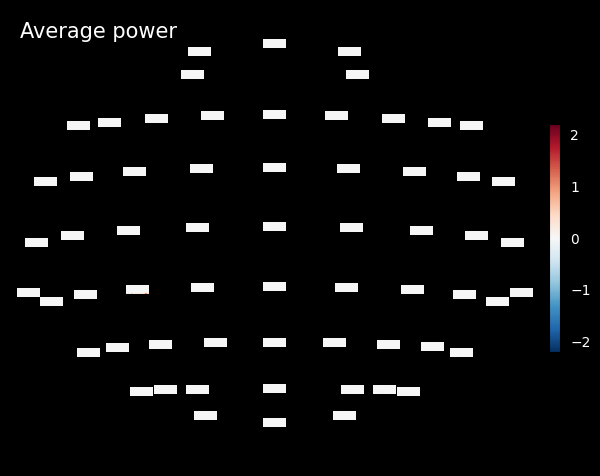

In [6]:
%matplotlib qt
power_mean_group = sum(list_power_odd_std)/len(list_power_odd_std)
power.data = power_mean_group
power.plot_topo(baseline=(-0.5, 0), mode='mean', title='Average power')

Applying baseline correction (mode: mean)


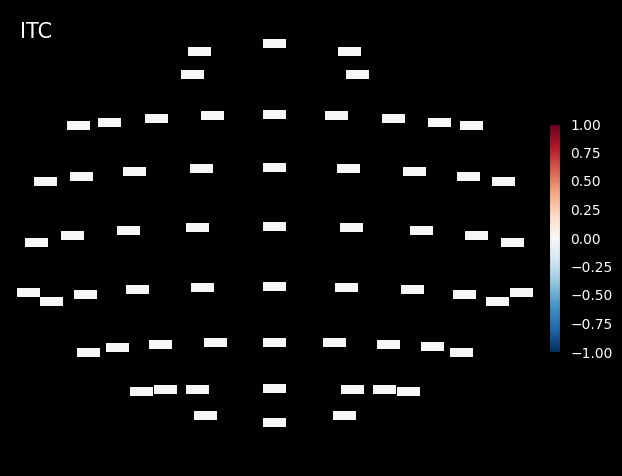

In [20]:
itc_mean_group = sum(list_power_odd_std)/len(list_power_odd_std)
itc.data = power_mean_group
itc.plot_topo(baseline=(-0.2, 0), mode='mean', title='ITC', vmin=-1, vmax=1)